In [1]:
import cv2
import matplotlib.pyplot as plt
import mtcnn
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from os import listdir
from os.path import isdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mtcnn.mtcnn import MTCNN
import time
import keras
import pickle
from sklearn.svm import SVC

# Definition des fonctions

In [95]:
detectors = mtcnn.MTCNN()

def decoupe_im(results,im):
    """ Store all face in a liste"""
    all_face = []
    box_coor = []
    for i in range(len(results)):
        x,y,w,h = results[i]['box'] # recupre les bbox
        x1,y1 = abs(x),abs(y)
        x2,y2 = x1+w,y1+h
        face = im[y1:y2,x1:x2]
        all_face.append(face)
        box_coor.append((x,y,w,h))
    return all_face,box_coor

def extract_face(image):
    """Function to detect all face in image"""
    #im = cv2.imread(image) #read image
    im = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #convert image to RGB
    results = detectors.detect_faces(im) #detect all face in image
    all_face,box_coor = decoupe_im(results,im) # store all image in liste
    all_face = [cv2.resize(all_face[i],(160,160)) for i in range(len(all_face))] #resize all image in liste 
    all_face = np.array(all_face)
    return all_face,box_coor

def extract_face_path(image):
    """Function to detect all face in image"""
    im = cv2.imread(image) #read image
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB) #convert image to RGB
    results = detectors.detect_faces(im) #detect all face in image
    all_face,box_coor = decoupe_im(results,im) # store all image in liste
    all_face = [cv2.resize(all_face[i],(160,160)) for i in range(len(all_face))] #resize all image in liste 
    all_face = np.array(all_face)
    return all_face,box_coor

def chargement_faces(path):
    faces = []
    #print(listdir(path))
    for x in listdir(path):
        #print("*** " , x)
        path1 = path + x
        face,_ = extract_face_path(path1)
        faces.append(face)
    return faces

def load_dataset(directory):
    """Directory hatrany am train na val"""
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        print(path)
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = chargement_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

def piplene_face(model, face_pixels):
    # scale pixel values
    #face_pixels = face_pixels.reshape(160,160,3)
    
    face_pixels = face_pixels.astype('float32')
    
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    print(samples.shape)
    yhat = model.predict(samples)
    
    return yhat[0]
  
def piplene_face_train(model, face_pixels):
    # scale pixel values
    #face_pixels = face_pixels.reshape(160,160,3)
    
    face_pixels = face_pixels.astype('float32')
    
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    print(samples[0].shape)
    yhat = model.predict(samples[0])

def piplene_face_test(model, face_pixels):
    # scale pixel values
    #face_pixels = face_pixels.reshape(160,160,3)
    
    face_pixels = face_pixels.astype('float32')
    
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    print(samples.shape)
    yhat = model.predict(samples)
    
    return yhat[0]

def extract_face1(image):
    all_face = []
    box_coor = []
    #im = cv2.imread(image) #read image
    im = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #convert image to RGB
    faces = face_cascade.detectMultiScale(im, scaleFactor=1.1, minNeighbors=5)
    for (x, y, w, h) in faces:
        face = im[y:y+h,x:x+w]
        face = cv2.resize(face,(160,160))
        all_face.append(face)
        box_coor.append((x,y,w,h))
    return np.array(all_face),box_coor

def count_liste(liste,text_match):
    l , con = np.unique(liste,return_counts = True)
    return con[list(l).index(text_match)]%2


# LOAD_MODEL

In [138]:
nom_model_svm = "E:/face_recognition/model_0503/svm_pers_igy_2021_0503.pkl"
nom_model_svm1 = "E:/face_recognition/model_16_03/svm_pers_igy_2021_16_03.pkl"
nom_model_svm_poly = "E:/face_recognition/model_0503/svm_pers_igy_2021_0503_poly.pkl"
nom_model_facenet = "E:/face_recognition/facenet_keras.h5"
nom_encode = "E:/face_recognition/model_0503/encoder_personnel_igy_2021_0503.pkl"
nom_encode1 = "E:/face_recognition/model_16_03/encoder_personnel_igy_2021_modif_16_03.pkl"

In [139]:
model_facenet = load_model(nom_model_facenet)
with open(nom_model_svm, 'rb') as file:
    model_svm = pickle.load(file)
with open(nom_model_svm1, 'rb') as file:
    model_svm1 = pickle.load(file)
with open(nom_encode, 'rb') as file:
    out_encoder = pickle.load(file)
with open(nom_encode1, 'rb') as file:
    out_encoder1 = pickle.load(file)

# CREATION TABLE

In [140]:
from sqlalchemy import create_engine
import pymysql
import mysql.connector
import pandas as pd 


In [141]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="face_recognition"
)

mycursor = mydb.cursor()
mycursor.execute("CREATE TABLE pointage_igy_2021_1503_2(id INT AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), heure TIME, date_arr DATE)")


ProgrammingError: 1050 (42S01): Table 'pointage_igy_2021_1503_2' already exists

In [119]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="face_recognition"
)

mycursor = mydb.cursor()
mycursor.execute("CREATE TABLE table3(id INT AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), arrive DATE, sortie DATE)")


# APPLICATION DANS UNE IMAGE

In [124]:
liste_nom=[]

1- L'utilisateur fait entrer l'image
2- Extractionn des face presente dans l'image via la fonction extract_face (il faut faire du resize en 160,160)
4- Normalisation
3- Standardisation des images de face ((im - mean)/(std))
4- Transfert learning avec Facenet (sortie 128)
5- Charger un svn et classification (ou autre classifier)
6- Prediction

0.9999999225077701


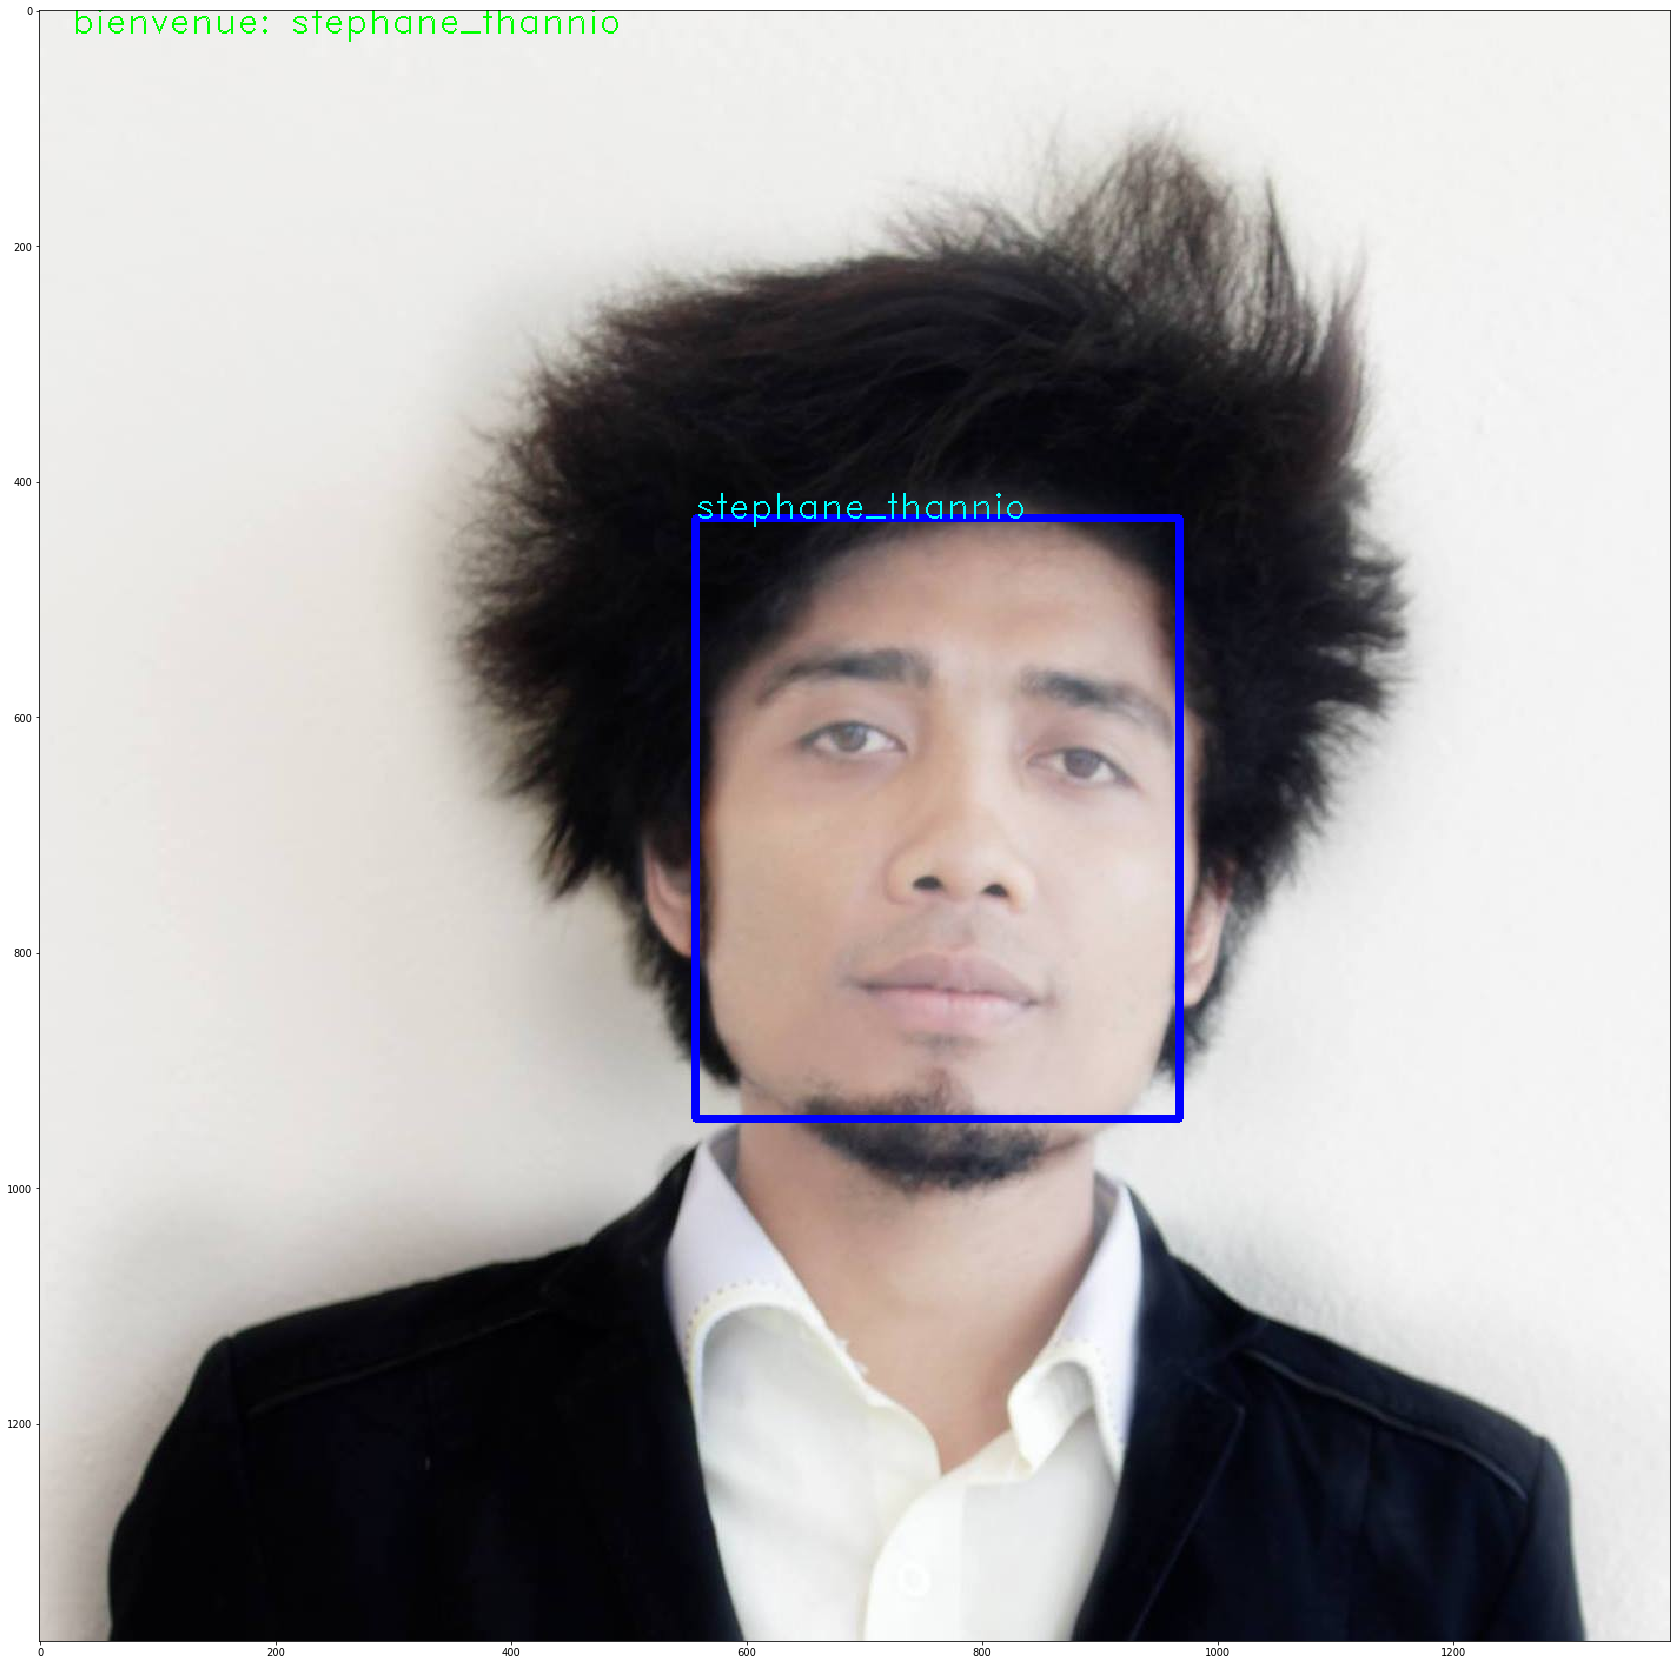

In [103]:
info = []
ar=[]
image = cv2.imread("E:/face_recognition/test_face_recognition_igy/53053606_412187432681435_7329605597521772544_o.jpg")
all_faces,box_coor = extract_face(image)
for i,face in enumerate(all_faces):
    l=[]
    moyenne,variance = face.mean(),face.std()
    face = (face - moyenne) / variance
    face = face.reshape(1,160,160,3)
    prediction = model_facenet.predict(face)
    #prediction = input_encoder.fit_transform(prediction)
    prediciton_face = model_svm.predict(prediction)
    prediciton_face_proba = model_svm.predict_proba(prediction)
    aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
    print(bb)
    if bb > 0.999:
      #raha mipredir anarana
        #u = time.strftime("%d-%m-%Y/%H:%M:%S")
        x,y,w,h = box_coor[i]
        #print(prediciton_face)
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
        #print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
        cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1)
        cv2.putText(image, 'bienvenue: ' + out_encoder.inverse_transform(np.array(prediciton_face))[0], (int(image.shape[0]/51),int(image.shape[1]/72)), cv2.FONT_HERSHEY_DUPLEX,1, (0, 255, 0), 1)
        cc = out_encoder.inverse_transform(np.array(prediciton_face))[0]
        if not(cc in liste_nom):
            print(liste_nom)
          #  print("fqzf")
            liste_nom.append(cc)
            #if localtime()[3:6]<(12,0,0):
            mycursor = mydb.cursor()
            mycursor.execute("INSERT INTO table2 VALUES (%s,%s, now(),null) ", ('',str(cc)))
            mydb.commit()                
        #update poi
            
  
plt.figure(figsize=(30,30))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)


0.6031155978726875
0.9999999677696098
0.9999998096272017
0.9935500307664614
0.9999993717075157
0.999999999804149
0.9911863518757918
0.9995896222467839
0.9999998126493007
0.9997365297429492
0.9999969902559415
0.9999661509573443
0.719075075760722
0.986909298620788
0.999999959008451
0.9537087541080589
0.9998967262175354


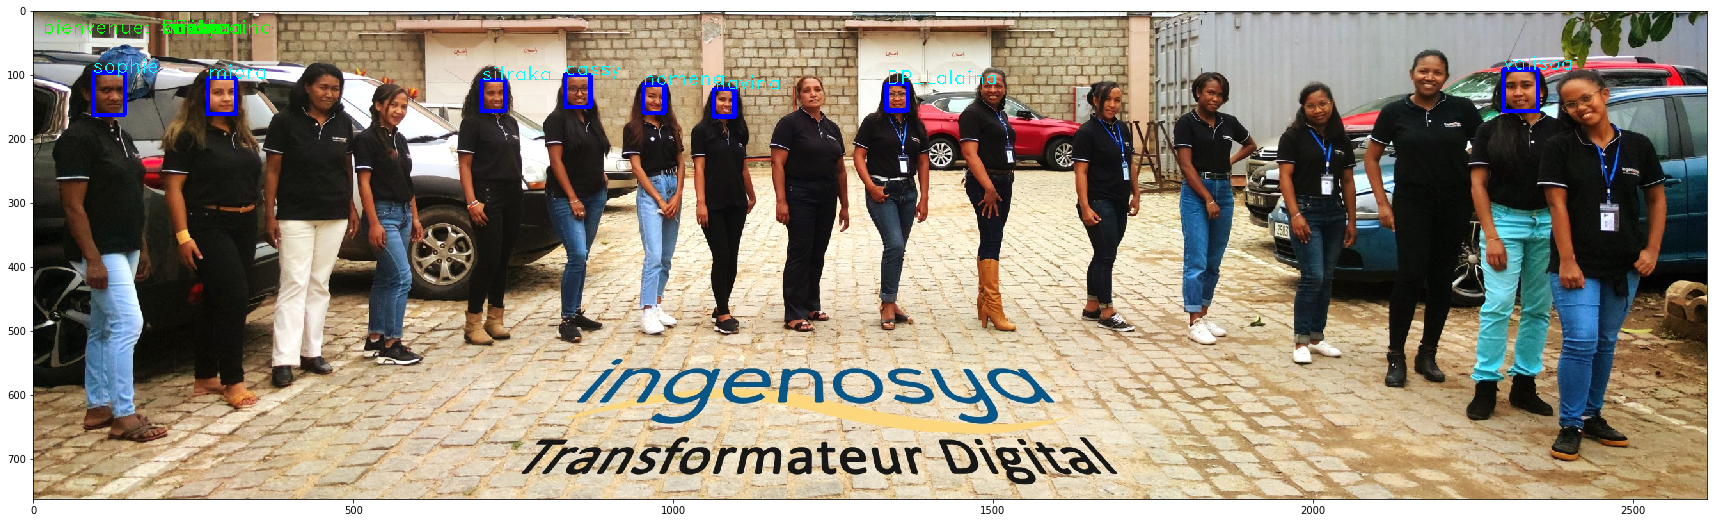

In [149]:
info = []
ar=[]
image = cv2.imread("E:/face_recognition/test_face_recognition_igy/158220617_4121688527927526_5376397255106365691_o.jpg")
all_faces,box_coor = extract_face(image)
for i,face in enumerate(all_faces):
    l=[]
    moyenne,variance = face.mean(),face.std()
    face = (face - moyenne) / variance
    face = face.reshape(1,160,160,3)
    prediction = model_facenet.predict(face)
    #prediction = input_encoder.fit_transform(prediction)
    prediciton_face = model_svm1.predict(prediction)
    prediciton_face_proba = model_svm1.predict_proba(prediction)
    aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
    print(bb)
    if bb > 0.9999:
      #raha mipredir anarana
        #u = time.strftime("%d-%m-%Y/%H:%M:%S")
        x,y,w,h = box_coor[i]
        #print(prediciton_face)
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
        #print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
        cv2.putText(image, out_encoder1.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1)
        cv2.putText(image, 'bienvenue: ' + out_encoder1.inverse_transform(np.array(prediciton_face))[0], (int(image.shape[0]/51),int(image.shape[1]/72)), cv2.FONT_HERSHEY_DUPLEX,1, (0, 255, 0), 1)
        cc = out_encoder1.inverse_transform(np.array(prediciton_face))[0]
        if not(cc in liste_nom):
            print(liste_nom)
          #  print("fqzf")
            liste_nom.append(cc)
            #if localtime()[3:6]<(12,0,0):
            mycursor = mydb.cursor()
            mycursor.execute("INSERT INTO table2 VALUES (%s,%s, now(),null) ", ('',str(cc)))
            mydb.commit()                
        #update poi
            
  
plt.figure(figsize=(30,30))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)


0.9999997885058294


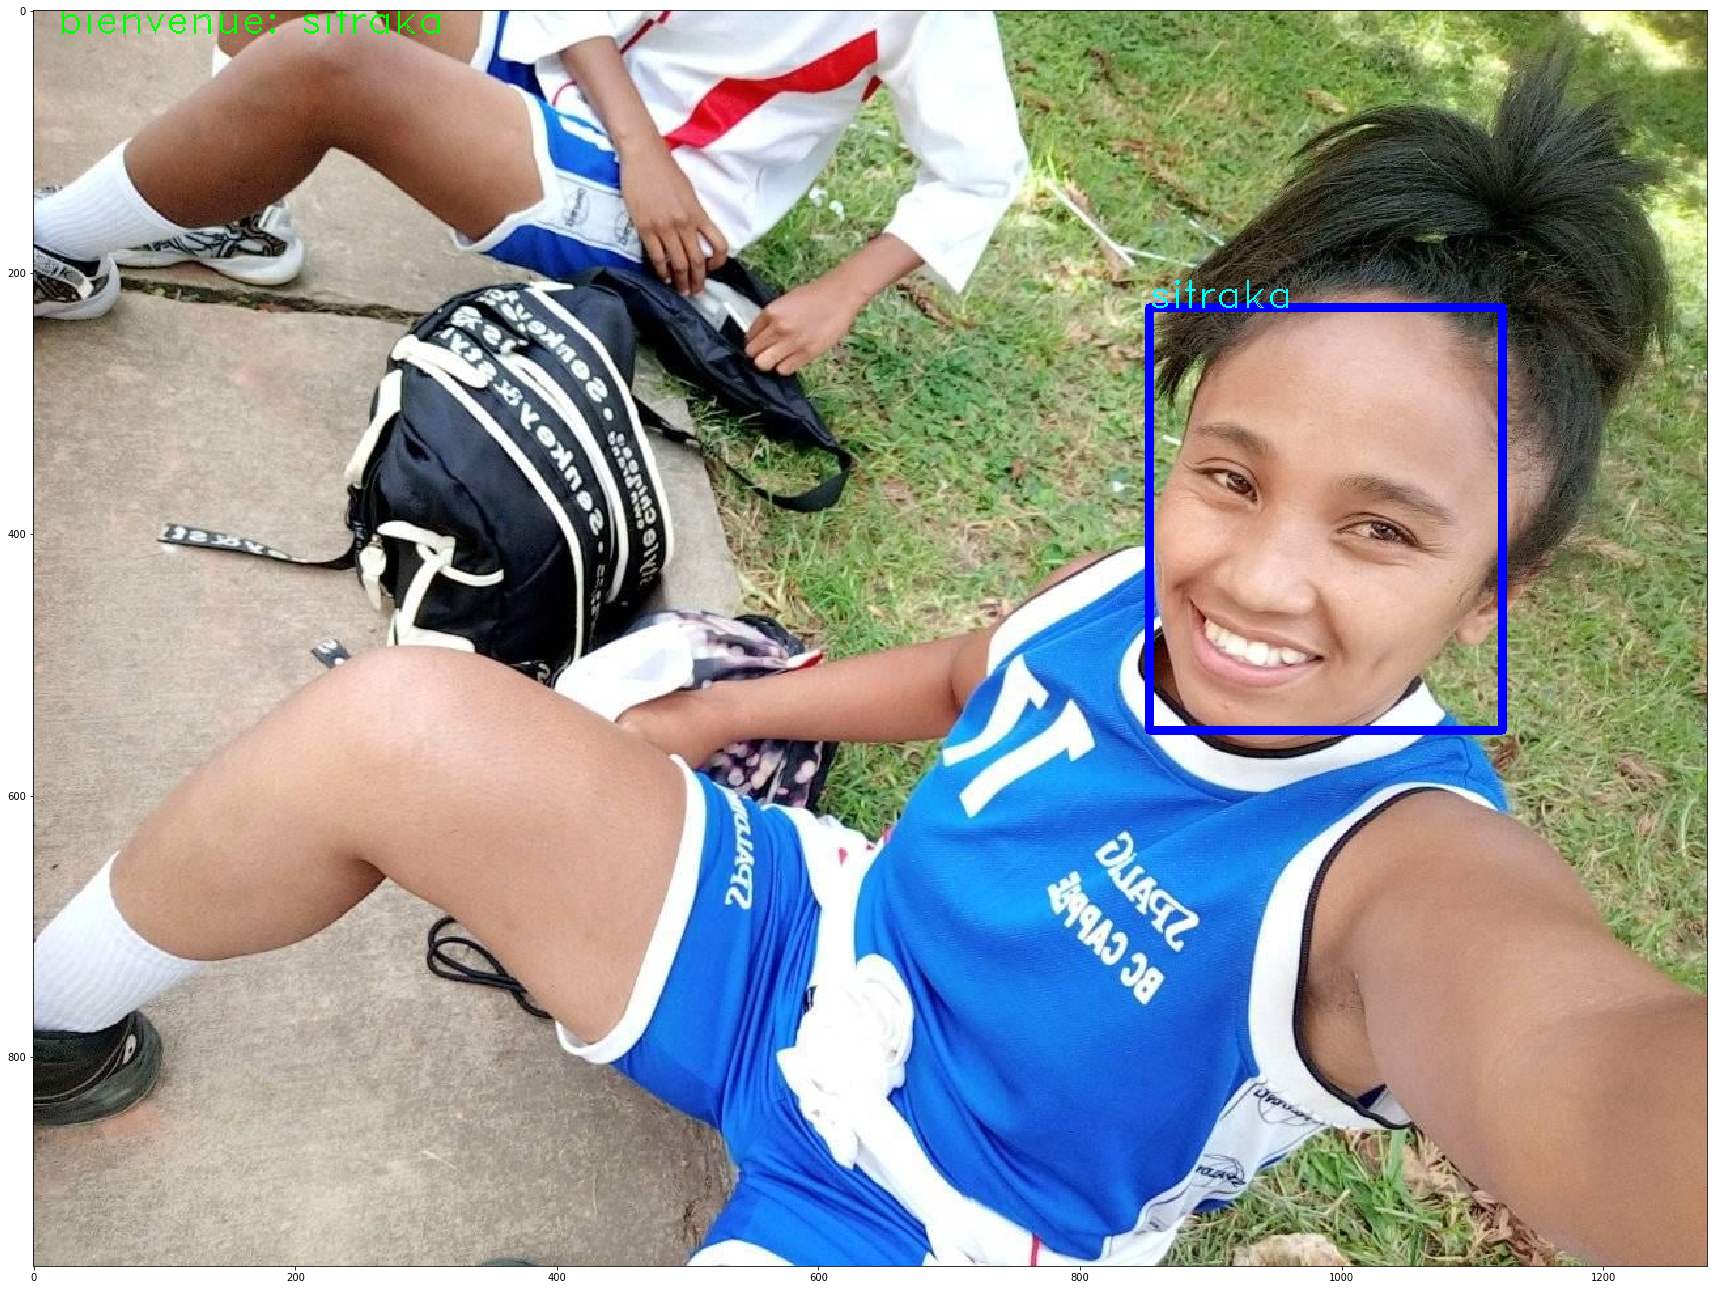

In [150]:
info = []
ar=[]
image = cv2.imread("E:/face_recognition/test_face_recognition_igy/139651574_2914150725485567_3398836724698950739_o.jpg")
all_faces,box_coor = extract_face(image)
for i,face in enumerate(all_faces):
    if localtime()[3:7] == (11,59,59,2):
        liste_nom1 = liste_nom
        liste_nom2 = [] 
        liste_nom = []
    moyenne,variance = face.mean(),face.std()
    face = (face - moyenne) / variance
    face = face.reshape(1,160,160,3)
    prediction = model_facenet.predict(face)
    #prediction = input_encoder.fit_transform(prediction)
    prediciton_face = model_svm.predict(prediction)
    prediciton_face_proba = model_svm.predict_proba(prediction)
    aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
    print(bb)
    if bb > 0.999:
      #raha mipredir anarana
        #u = time.strftime("%d-%m-%Y/%H:%M:%S")
        x,y,w,h = box_coor[i]
        #print(prediciton_face)
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
        #print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
        cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1)
        cv2.putText(image, 'bienvenue: ' + out_encoder.inverse_transform(np.array(prediciton_face))[0], (int(image.shape[0]/51),int(image.shape[1]/72)), cv2.FONT_HERSHEY_DUPLEX,1, (0, 255, 0), 1)
        cc = out_encoder.inverse_transform(np.array(prediciton_face))[0]
        if not(cc in liste_nom) and localtime()[3:7]<(12,0,0,0):
            print(liste_nom)
            liste_nom.append(cc)
            #if localtime()[3:6]<(12,0,0):
            mycursor = mydb.cursor()
            mycursor.execute("INSERT INTO table3 VALUES (%s,%s, now(),null) ", ('',str(cc)))
            mydb.commit()
        if localtime()[3:7] > (12,0,0,1):
            if cc in liste_nom1:
                mycursor = mydb.cursor()
                mycursor.execute("UPDATE table3 set sortie = now() WHERE arrive is NULL AND name = (%s)", (str(cc)))
                mydb.commit()
            else:
                liste_nom2.append(cc)
                mycursor = mydb.cursor()
                mycursor.execute("INSERT INTO table3 VALUES (%s,%s, now(),null) ", ('',str(cc)))
                mydb.commit() 
                
                
        #update poi
            
  
plt.figure(figsize=(30,30))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [134]:
liste_nom1

[]

In [136]:
localtime()[3:7]

(9, 53, 10, 1)

In [ ]:
info = []
ar=[]
image = cv2.imread("E:/face_recognition/test_face_recognition_igy/53053606_412187432681435_7329605597521772544_o.jpg")
all_faces,box_coor = extract_face(image)
for i,face in enumerate(all_faces):
    moyenne,variance = face.mean(),face.std()
    face = (face - moyenne) / variance
    face = face.reshape(1,160,160,3)
    prediction = model_facenet.predict(face)
    #prediction = input_encoder.fit_transform(prediction)
    prediciton_face = model_svm.predict(prediction)
    prediciton_face_proba = model_svm.predict_proba(prediction)
    aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
    print(bb)
    if bb > 0.999:
      #raha mipredir anarana
        #u = time.strftime("%d-%m-%Y/%H:%M:%S")
        x,y,w,h = box_coor[i]
        #print(prediciton_face)
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
        #print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
        cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1)
        cv2.putText(image, 'bienvenue: ' + out_encoder.inverse_transform(np.array(prediciton_face))[0], (int(image.shape[0]/51),int(image.shape[1]/72)), cv2.FONT_HERSHEY_DUPLEX,1, (0, 255, 0), 1)
        cc = out_encoder.inverse_transform(np.array(prediciton_face))[0]
        
        
        
        
        
        liste_nom.append(cc)    
        manisa = count_liste(liste_nom,cc)  
        if manisa == 0:
            mycursor = mydb.cursor()
            mycursor.execute("INSERT INTO table2 VALUES (%s,%s, now(),null) ", ('',str(cc)))
            mydb.commit()
        if manisa ==1:
            mycursor = mydb.cursor()
            mycursor.execute("UPDATE table2 set arrive = now() WHERE arrive is NULL AND name = (%s)", (str(cc)))
            mydb.commit()
            
        
        
        
        if not(cc in liste_nom):
            print(liste_nom)
          #  print("fqzf")
            liste_nom.append(cc)
            if localtime()[3:6]<(12,0,0):
                mycursor = mydb.cursor()
                mycursor.execute("INSERT INTO table2 VALUES (%s,%s, now(),null) ", ('',str(cc)))
                mydb.commit()
        if cc in liste_nom:
            mycursor = mydb.cursor()
            mycursor.execute("UPDATE table2 set arrive = now() WHERE arrive is NULL AND name = (%s)", (str(cc)))
            mydb.commit()
                
        #update poi
            
  
plt.figure(figsize=(30,30))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [74]:
qqq = ["avotra","fab","avotra","sitraka","datoa"]

In [78]:
l , con = np.unique(qqq,return_counts = True)

In [89]:
con[list(l).index("avotra")]%2

0

In [115]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="face_recognition"
)
mycursor = mydb.cursor()
mycursor.execute("""SELECT name FROM table2 """)
#mydb.commit()
rows = mycursor.fetchall()
for row in rows:
   print(row[0])

fabrice
sitraka
fanasina
stephane_thannio


In [94]:
count_liste(qqq,"avotra")

0

In [65]:
from time import gmtime, strftime,localtime
i = localtime()
i


time.struct_time(tm_year=2021, tm_mon=3, tm_mday=15, tm_hour=14, tm_min=59, tm_sec=18, tm_wday=0, tm_yday=74, tm_isdst=0)

In [69]:
i[3:6] > (14,44,31)

True

In [70]:
i[3:6]

(14, 59, 18)

In [67]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="face_recognition"
)
var1="RABESERANANA"
var2=""
var3="Fah"
mycursor = mydb.cursor()
mycursor.execute("INSERT INTO vrai VALUES (%s,%s, now(),now())", ('',str(cc)))
mydb.commit() 


In [ ]:
cc

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="face_recognition"
)

mycursor = mydb.cursor()
mycursor.execute("INSERT INTO vrai(name,heure,date_arr) values ('Test1',now(),now())")
mydb.commit() 

In [ ]:
result = mycursor.execute("select * from vrai")
print(result)

In [ ]:
update = """
    INSERT INTO 
        myDB.newtable 
        (ID,Record,Latitude,Longitude,code) 
    VALUES 
        (%s,%s,%s,%s,%s)
"""
cursor2.execute(update, (ID, Record, str(Latitude), str(Longitude), code))



In [ ]:
mycursor.execute("CREATE TABLE customers (id INT AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), address VARCHAR(255))")

In [ ]:
sql = "INSERT INTO customers (name, address) VALUES (%s, %s)"
val = ("Jh", "Highway 21")
mycursor.execute(sql, val)
mydb.commit()

In [ ]:
info = []
ar=[]
cap = cv2.VideoCapture("E:/face_recognition/test_face_recognition_igy/VIDEO0051.mp4")
while True:
    _,image = cap.read()
    image = cv2.resize(image,(0,0),fx=0.7,fy=0.7)
    all_faces,box_coor = extract_face(image)
    for i,face in enumerate(all_faces):
        moyenne,variance = face.mean(),face.std()
        face = (face - moyenne) / variance
        face = face.reshape(1,160,160,3)
        prediction = model_facenet.predict(face)
        #prediction = input_encoder.fit_transform(prediction)
        prediciton_face = model_svm.predict(prediction)
        prediciton_face_proba = model_svm.predict_proba(prediction)
        aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
        print(bb)
        if bb > 0.99999:
          #raha mipredir anarana
          x,y,w,h = box_coor[i]
          print(prediciton_face)
          cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
          print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
          cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1) 
        cv2.imshow('PRESENCE_IGY',image)
    if cv2.waitKey(1) & 0xFF == ord('Q'.lower()):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
info = []
ar=[]
cap = cv2.VideoCapture(0)
while True:
    _,image = cap.read()
    image = cv2.resize(image,(0,0),fx=0.25,fy=0.25)
    all_faces,box_coor = extract_face(image)
    for i,face in enumerate(all_faces):
        moyenne,variance = face.mean(),face.std()
        face = (face - moyenne) / variance
        face = face.reshape(1,160,160,3)
        prediction = model_facenet.predict(face)
        #prediction = input_encoder.fit_transform(prediction)
        prediciton_face = model_svm.predict(prediction)
        prediciton_face_proba = model_svm.predict_proba(prediction)
        aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
        print(bb)
        if bb > 0.9999:
          #raha mipredir anarana
          x,y,w,h = box_coor[i]
          print(prediciton_face)
          cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
          print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
          cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1) 
        cv2.imshow('PRESENCE_IGY',image)
    if cv2.waitKey(1) & 0xFF == ord('Q'.lower()):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
info = []
ar=[]
cap = cv2.VideoCapture("E:/face_recognition/test_face_recognition_igy/VIDEO0051.mp4")

while True:
    _,image = cap.read()
    image = cv2.resize(image,(0,0),fx=0.05,fy=0.05)
    all_faces,box_coor = extract_face1(image)
    for i,face in enumerate(all_faces):
        moyenne,variance = face.mean(),face.std()
        face = (face - moyenne) / variance
        face = face.reshape(1,160,160,3)
        prediction = model_facenet.predict(face)
        #prediction = input_encoder.fit_transform(prediction)
        prediciton_face = model_svm.predict(prediction)
        prediciton_face_proba = model_svm.predict_proba(prediction)
        aa,bb = np.argmax(prediciton_face_proba),np.max(prediciton_face_proba)
        #print(bb)
        if bb > 0.9999:
          #raha mipredir anarana
          x,y,w,h = box_coor[i]
          #print(prediciton_face)
          cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),5)
          #print( out_encoder.inverse_transform(np.array(prediciton_face))[0])
          cv2.putText(image, out_encoder.inverse_transform(np.array(prediciton_face))[0], (x,y), cv2.FONT_HERSHEY_DUPLEX,1, (255, 255, 0), 1) 
        cv2.imshow('PRESENCE_IGY',image)
    if cv2.waitKey(1) & 0xFF == ord('Q'.lower()):
        break

cap.release()
cv2.destroyAllWindows()